In [77]:
# generate data
import Distributions
using Random
using Plots

Random.seed!(42)

n_samples = 10
dimensionality = 2
rθ = [-0.9, 0.5]
ms = [[0.9, 0.1], [0.2, 0.8]]
inputs = randn(n_samples, dimensionality)
σ(w, x) = 1/(1+exp(-w'x))
A = [[0.85 0.3; 0.15 0.7], [0.4 0.6; 0.6 0.4]]
s = [[0.8, 0.2]]
for i in 2:n_samples
    push!(s, rand(A)*s[end])
end
πs = [σ(rθ, ms[findmax(s[1])[2]]) for i in 1:n_samples]
outputs = [rand(Distributions.Bernoulli(πs[i])) for i in 1:n_samples];

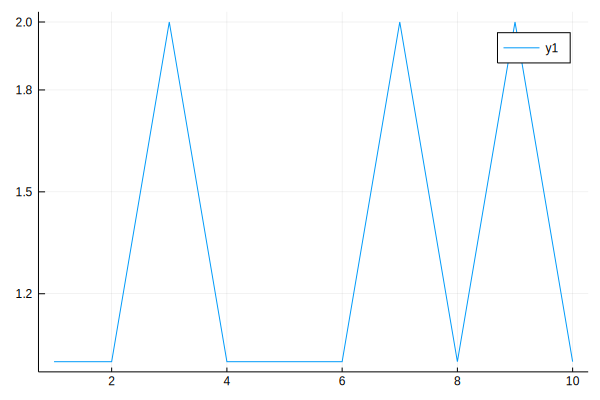

In [78]:
plot([findmax(x)[2] for x in s])

In [79]:
using Turing

In [80]:
logistic(w,x) = 1/(1+exp(-w'x))

@model user_preferences(outputs, σ²; mpriors, D=2) = begin
    
    K = length(mpriors[1])
    n_samples = length(outputs)
    weights   = Vector{Vector}(undef, n_samples)
    
    # State sequence.
    s = tzeros(Int, n_samples)

    m = Vector(undef, K)

    # Transition matrix.
    T = Vector{Vector}(undef, K)
    for i in 1:K
        T[i] ~ Dirichlet(ones(K)/K)
        m[i] ~ MvNormal(mpriors[i], 1e-2)
    end
    
    θ ~ MvNormal(zeros(D), sqrt(σ²)) 
    
    s[1] ~ Categorical(K)
    weights[1] ~ MvNormal(m[s[1]], 1e-4)
    
    for i in 2:n_samples
        s[i] ~ Categorical(vec(T[s[i-1]]))
        weights[i] ~ MvNormal(m[s[i]], sqrt(10.0))
#         @show weights
    end

    for i in 1:n_samples
        π = logistic(weights[i], θ)
        outputs[i] ~ Bernoulli(π)
    end
end;

In [ ]:
# Settings of the Hamiltonian Monte Carlo (HMC) sampler.
iterations = 100
ϵ = 0.05
τ = 10
chains = sample(user_preferences(outputs, 0.1, mpriors=ms), Gibbs(HMC(0.05, 10, :weights, :θ), PG(20, :s)), iterations)

weights = Vector{T} where T[[0.9239126367086867, 0.10059981576912062], [-1.1597920432140758, -5.556793184280313], #undef, #undef, #undef, #undef, #undef, #undef, #undef, #undef]
weights = Vector{T} where T[[0.9239126367086867, 0.10059981576912062], [-1.1597920432140758, -5.556793184280313], [3.6968702409039973, -5.358196075665139], #undef, #undef, #undef, #undef, #undef, #undef, #undef]
weights = Vector{T} where T[[0.9239126367086867, 0.10059981576912062], [-1.1597920432140758, -5.556793184280313], [3.6968702409039973, -5.358196075665139], [-0.40193772147058493, -2.808436989997813], #undef, #undef, #undef, #undef, #undef, #undef]
weights = Vector{T} where T[[0.9239126367086867, 0.10059981576912062], [-1.1597920432140758, -5.556793184280313], [3.6968702409039973, -5.358196075665139], [-0.40193772147058493, -2.808436989997813], [1.4388125679923172, 0.8287135187410337], #undef, #undef, #undef, #undef, #undef]
weights = Vector{T} where T[[0.9239126367086867, 0.10059981576912062], [-1.15979

Excessive output truncated after 542346 bytes.

In [143]:
d = 2

sumstats = summarize(chains, mean, std)
mθ, vθ   = sumstats.nt.mean[1:2], sumstats.nt.std[1:2]
mw       = [sumstats.nt.mean[i:i+d-1] for i in d+1:d:d*n_samples+d]

100-element Vector{Vector{Float64}}:
 [-0.3707910707212212, 0.10978605027468057]
 [-0.6446666563145693, 0.06717351737636983]
 [-0.25525664403644993, -0.4512387887354433]
 [-0.10749051898140538, -1.2292644445478855]
 [1.9248749644648147, -1.3448797286421503]
 [-1.2899085176062282, 0.9202588989138918]
 [-0.7085719764023278, -0.08443717833487417]
 [-0.20936265676234958, -0.09501313409301644]
 [-2.7531792125640666, -0.18630473757698693]
 [1.2793799926371148, -0.06325146360812399]
 [0.6676239456599308, 0.8426771642600577]
 [0.02439750162156193, 1.4961241621475294]
 [0.1597748525973603, -0.1590707063080306]
 ⋮
 [0.823484460352815, -1.0666512819434288]
 [0.6795790419771863, 1.2806736975993103]
 [0.440946461022478, -0.8640322692545783]
 [-1.6402924538516876, 1.4604938242156038]
 [-1.1688977937419558, 1.3804005630694323]
 [-0.9787819220013382, 1.6242655471971208]
 [-2.130502370652669, 2.2312911097091113]
 [0.3238102979171723, -0.3767963371931768]
 [3.2506938920253976, -1.340027464418827]
 [-0.8

In [144]:
e_outputs = round.([logistic(mθ, mw[i]) for i in 1:n_samples])

100-element Vector{Float64}:
 1.0
 1.0
 0.0
 0.0
 0.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 1.0
 0.0
 ⋮
 0.0
 1.0
 0.0
 1.0
 1.0
 1.0
 1.0
 0.0
 0.0
 1.0
 1.0
 1.0

In [145]:
sum(outputs .== e_outputs)

81